In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/CO2 emissions - North America.csv')
df.head()

,North-America Annual CO2 emissions,million metric tonnes carbon dioxide
0,1949,2206.690829
1,1950,2382.046176
2,1951,2526.687327
3,1952,2473.373964
4,1953,2536.892888


In [4]:
df.tail()

,North-America Annual CO2 emissions,million metric tonnes carbon dioxide
65,2014,6468.127089
66,2015,6336.860299
67,2016,6241.322193
68,2017,6215.118995
69,2018,6381.236073


In [5]:
df.shape

(70, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   North-America Annual CO2 emissions     70 non-null     int64  
 1    million metric tonnes carbon dioxide  70 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


In [ ]:
df.isnull().sum()

North-America Annual CO2 emissions       0
 million metric tonnes carbon dioxide    0
dtype: int64

In [6]:
time = pd.date_range(start='1/1/1949',periods=70,freq='Y')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['North-America Annual CO2 emissions'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [7]:
df.columns=['million_tonnes']

In [ ]:
df.head()

,million_tonnes
time_stamp,
1949-12-31,2206.690829
1950-12-31,2382.046176
1951-12-31,2526.687327
1952-12-31,2473.373964
1953-12-31,2536.892888


In [ ]:
df.tail()

,million_tonnes
time_stamp,
2014-12-31,6468.127089
2015-12-31,6336.860299
2016-12-31,6241.322193
2017-12-31,6215.118995
2018-12-31,6381.236073


In [8]:
plt.rcParams['figure.figsize'] = [15,8]

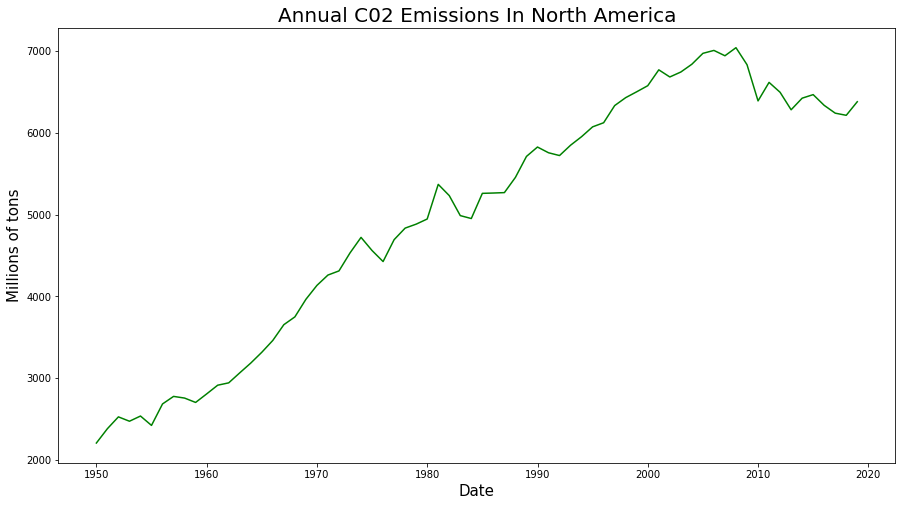

In [9]:
plt.plot(df,color='green')
plt.title('Annual C02 Emissions In North America',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Millions of tons',fontsize=15)
plt.show()

In [10]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [11]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['million_tonnes'] = df['million_tonnes'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [15]:
#Split data set into testing dataset and train dataset
train_size = 58
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 2
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(56, 2)
(56,)
(10, 2)
(10,)


In [17]:
!pip install -q -U keras-tuner

In [18]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 64,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='co2_em_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=10,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 10s]
val_mape: 2.1702158451080322

Best val_mape So Far: 2.107761859893799
Total elapsed time: 00h 01m 46s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/co2_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 24
dropout: False
learning_rate: 0.0032160389394253097
Dropout_rate: 0.4
units_1: 40
units_2: 16
units_3: 16
Score: 2.107761859893799
Trial summary
Hyperparameters:
num_layers: 5
units_0: 40
dropout: True
learning_rate: 0.0038134765898846113
Dropout_rate: 0.0
units_1: 56
units_2: 16
units_3: 24
units_4: 8
Score: 2.1394851207733154
Trial summary
Hyperparameters:
num_layers: 3
units_0: 56
dropout: True
learning_rate: 0.010596262520512652
Dropout_rate: 0.0
units_1: 8
units_2: 8
Score: 2.1486310958862305
Trial summary
Hyperparameters:
num_layers: 4
units_0: 48
dropout: True
learning_rate: 0.00021080415469627926
Dropout_rate: 0.0
units_1: 48
units_2: 24
units_3: 24
units_4: 48
Score: 2.1702158451080322
Trial summary
Hyperparameters:
num_layers: 4
units_0: 48
dropout: False
learning_rate: 0.005022336461695035
Dropout_rate: 0.1
un

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 2))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                72        
                                                                 
 dense_1 (Dense)             (None, 40)                1000      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,113
Trainable params: 1,113
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

In [26]:
model = Sequential()
model.add(Dense(32,activation='relu',input_dim = 2))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.000052160389394253097)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 10, epochs = 500,callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/500
6/6 [==============================] - 1s 64ms/step - loss: 81.4035 - mape: 81.4035 - val_loss: 79.2824 - val_mape: 79.2824
Epoch 2/500
6/6 [==============================] - 0s 12ms/step - loss: 80.7782 - mape: 80.7782 - val_loss: 78.7976 - val_mape: 78.7976
Epoch 3/500
6/6 [==============================] - 0s 11ms/step - loss: 80.1587 - mape: 80.1587 - val_loss: 78.3148 - val_mape: 78.3148
Epoch 4/500
6/6 [==============================] - 0s 14ms/step - loss: 79.5360 - mape: 79.5360 - val_loss: 77.8344 - val_mape: 77.8344
Epoch 5/500
6/6 [==============================] - 0s 11ms/step - loss: 78.9124 - mape: 78.9124 - val_loss: 77.3562 - val_mape: 77.3562
Epoch 6/500
6/6 [==============================] - 0s 10ms/step - loss: 78.2869 - mape: 78.2869 - val_loss: 76.8803 - val_mape: 76.8803
Epoch 7/500
6/6 [==============================] - 0s 11ms/step - loss: 77.6836 - mape: 77.6836 - val_loss: 76.4019 - val_mape: 76.4019
Epoch 8/500
6/6 [==============================]

In [27]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [28]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 6.30 
Test MAPE : 2.99 


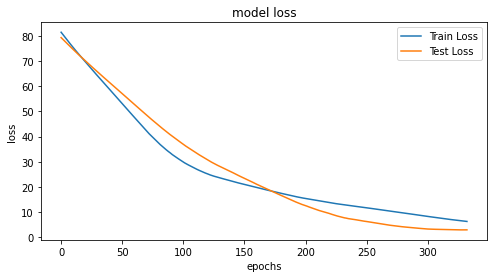

In [29]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [30]:
import seaborn as sns

In [33]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(56,66)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

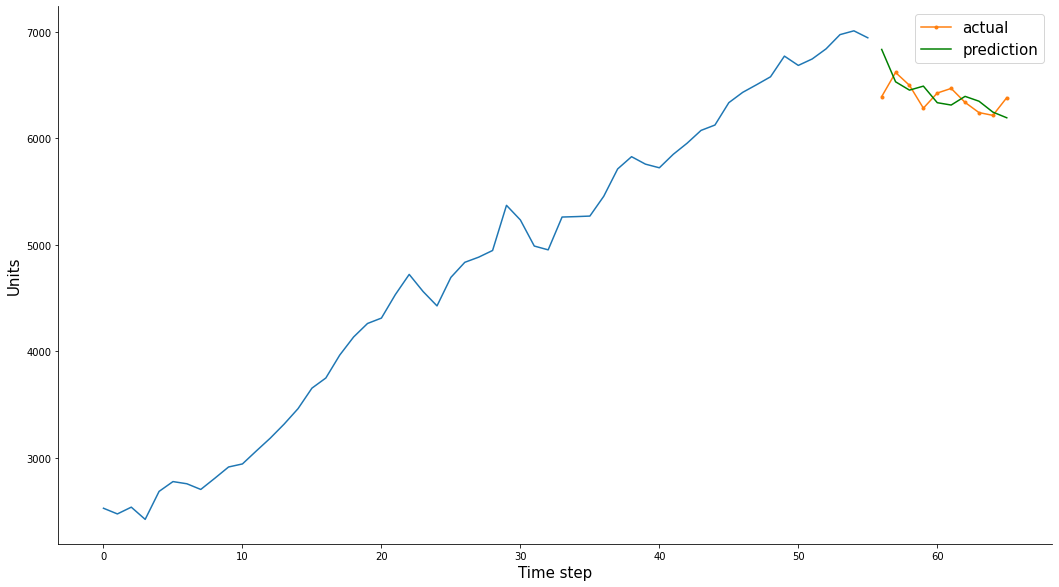

In [34]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)